https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1


https://towardsdatascience.com/similarity-metrics-in-nlp-acc0777e234c 

https://www.youtube.com/watch?v=Ey81KfQ3PQU


Model semantic search: 'multi-qa-MiniLM-L6-cos-v1'

Model assymetric : 'msmarco-MiniLM-L-6-v3'

In [1]:
# import sys
# import os

# # Add the 'Functions' directory to the Python path
# sys.path.append(os.path.abspath('../../Functions'))


from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
from Functions.NLP.data_with_nlp import *
from Functions.BERT.bert import *
from Functions.pipeline import *

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
# Import argsort
from numpy import argsort
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt

/home/gabrielabib/.conda/envs/nova/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
protocols = pd.read_csv('./BERT/protocol_exploded.csv')
protocols

,A1,A2,A3,A4,A5,A6
0,Cefaleia crónica,Distúrbios do equilíbrio com quedas frequentes,Doenças neuromusculares e genéticas,Distúrbio de aprendizagem,Demência com dúvida diagnóstica,Doença desmielinizante
1,Cefaleia refratária,Distonia,dores neuropáticas refratárias,Retardo psicomotor,Demência rapidamente progressiva,Esclerose múltipla
2,Enxaqueca persistente,Parkinson,parestesias recorrentes e/ou progressivas,NaN,NaN,Mielite transversa
3,NaN,Tremor essencial,paraplegias e paresias,NaN,NaN,Doença de Devic
4,NaN,Ataxia ou descoordenação motora,esclerose lateral amiotrófica,NaN,NaN,Leucoencefalopatia multifocal progressiva
5,NaN,"Coreia, balismo ou movimentos involuntários",suspeita de miopatias,NaN,NaN,Neurite óptica
6,NaN,NaN,miastenia graves e outros transtornos neuromus...,NaN,NaN,Leucodistrofias
7,NaN,NaN,"amiotrofias espinhais e síndromes correlatas, ...",NaN,NaN,Síndrome de Van der Knaap
8,NaN,NaN,doenças neurogenéticas,NaN,NaN,Doença neuroimunológica
9,NaN,NaN,NaN,NaN,NaN,Doença autoimune


In [3]:
list(protocols['A1'].dropna())

['Cefaleia crónica', 'Cefaleia refratária', 'Enxaqueca persistente']

In [4]:
baseline = protocols.columns.to_list()

In [5]:
# # 1. Data cleaning
reference = []

for col in baseline:
    
    protocols2 = protocols.copy()
    protocols2 = protocols2[[col]].dropna()

    lower_text(protocols2,col, col)
    remove_stop_words(protocols2,col, col)
    spacy_lemmatizer(protocols2,col, col)

    reference.append(list(protocols2[col].dropna()))

    
# [reference.append(list(spacy_lemmatizer(remove_stop_words(lower_text(protocols[[col]].copy().dropna(), col), col), col)[col].dropna())) for col in baseline]

reference

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-d

[['cefaleia crónico', 'cefaleia refratária', 'enxaqueca persistente'],
 ['distúrbio equilíbrio queda frequente',
  'distonia',
  'parkinson',
  'tremor essencial',
  'ataxio descoordenação motoro',
  'coreia balismo movimento involuntário'],
 ['doença neuromuscular genético',
  'dor neuropático refratário',
  'parestesia recorrente e/ou progressivo',
  'paraplegia paresio',
  'esclerose lateral amiotrófico',
  'suspeito miopatia',
  'miastenia grave outro transtorno neuromuscular',
  'amiotrofia espinhal síndromes correlato polineuropatia outro transtorno sistema nervoso periférico snp',
  'doença neurogenético'],
 ['distúrbio aprendizagem', 'retardo psicomotor'],
 ['demência dúvido diagnósticar', 'demência rapidamente progressivo'],
 ['doença desmielinizante',
  'esclerose múltiplo',
  'mielite transverso',
  'doença devic',
  'leucoencefalopatia multifocal progressivo',
  'neurite óptico',
  'leucodistrofia',
  'síndrome van der knaap',
  'doença neuroimunológico',
  'doença autoimun

In [6]:
alertP1 = connection('credentials.txt')
data = pre_process(alertP1)


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
96


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
split_text_df = data[['COD_REFERENCIA', 'Texto', 'text_length']]
split_text_df = split_text_df[split_text_df['text_length'] > 0]
split_text_df['text_split'] = split_text_df['Texto'].apply(lambda x: x.split("."))
split_text_df =  split_text_df.explode('text_split')
lower_text(split_text_df,'text_split', 'text_split')
remove_stop_words(split_text_df,'text_split', 'text_split')
spacy_lemmatizer(split_text_df,'text_split', 'text_split')
split_text_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,COD_REFERENCIA,Texto,text_length,text_split
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,doente 71 ano idade tremor acentuar membro alt...
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,
1537,LOHHLSTU,Sem relatorio clinico,21,relatorio clinico
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,trazer inumero relatorio ida hgo-su vulvo-vagi...
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,relatorio sobre ida crise epilepsio ter ser me...
...,...,...,...,...
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,d
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,l
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,estimativa 161 perturbação sono alteração memória
1227,LSHVHUHL,Dte 79 anos com AVC HE ha 6 meses comm sequela...,149,dte 79 ano avc he ha 6 mês comm sequelo disart...


In [8]:
# model_name = 'pucpr/biobertpt-all'
model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3'

In [9]:
from sentence_transformers import SentenceTransformer

In [10]:
def bert_easy(dataset, column_name, baseline_list, suffix = 'max', model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3'):
    
    from sklearn.metrics.pairwise import cosine_similarity

    model = SentenceTransformer(model_name)

    # Creating a list to store the text
    referrals = dataset[column_name].tolist()

    # Creating a list to store the column names
    columns_bert = []

    # Looping through the baseline list
    for index, protocol in enumerate(baseline_list):

        # Creating a list with the protocol and the referrals
        sentences = [protocol] + referrals
        
        # Encoding the sentences
        sentences_vectors = model.encode(sentences)

        # Calculating the cosine similarity
        results = cosine_similarity([sentences_vectors[0]], sentences_vectors[1:])

        # Appending the information on the dataset
        column_name = 'prot_' + str(index)
        columns_bert.append(column_name)
        dataset[column_name] = results[0]

    dataset[suffix + '_score'] = dataset[columns_bert].max(axis=1)
    dataset.drop(columns_bert, axis=1, inplace=True)
    
    return dataset


In [11]:
for i, protocol in enumerate(reference):
    print(i)

0
1
2
3
4
5


In [12]:
split_text_df2 = split_text_df.copy()

for i, protocol in enumerate(reference):

    bert_easy(split_text_df2, 'text_split', protocol, suffix = str(i), model_name = model_name)

split_text_df2

,COD_REFERENCIA,Texto,text_length,text_split,0_score,1_score,2_score,3_score,4_score,5_score
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,doente 71 ano idade tremor acentuar membro alt...,0.124159,0.441217,0.311656,0.219137,0.250608,0.430345
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,,0.077163,0.406086,0.098522,0.153451,0.064503,0.112181
1537,LOHHLSTU,Sem relatorio clinico,21,relatorio clinico,0.279113,0.285873,0.274648,0.283002,0.237314,0.395145
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,trazer inumero relatorio ida hgo-su vulvo-vagi...,0.158817,0.295417,0.192359,0.161773,0.156821,0.281982
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,relatorio sobre ida crise epilepsio ter ser me...,0.273248,0.256537,0.377595,0.101922,0.224389,0.390945
...,...,...,...,...,...,...,...,...,...,...
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,d,0.174138,0.362244,0.186413,0.267856,0.181888,0.127736
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,l,0.072572,0.156041,0.137902,-0.031269,0.136412,0.080419
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,estimativa 161 perturbação sono alteração memória,0.316997,0.309291,0.363478,0.355510,0.279471,0.367594
1227,LSHVHUHL,Dte 79 anos com AVC HE ha 6 meses comm sequela...,149,dte 79 ano avc he ha 6 mês comm sequelo disart...,0.173630,0.247006,0.233176,0.276076,0.275436,0.291725


In [13]:
split_text_df2.info()

desirable = ['0_score','1_score','2_score','3_score','4_score','5_score']
undesirable = ['prot_0','prot_1','prot_2','prot_3','prot_4','prot_5','prot_6','prot_7','prot_8','prot_9','prot_10','prot_11','prot_12','prot_13']

# split_text_df2.drop(undesirable, axis=1, inplace=True)

split_text_df2



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 630 to 1227
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COD_REFERENCIA  7924 non-null   object 
 1   Texto           7924 non-null   object 
 2   text_length     7924 non-null   int64  
 3   text_split      7924 non-null   object 
 4   0_score         7924 non-null   float32
 5   1_score         7924 non-null   float32
 6   2_score         7924 non-null   float32
 7   3_score         7924 non-null   float32
 8   4_score         7924 non-null   float32
 9   5_score         7924 non-null   float32
dtypes: float32(6), int64(1), object(3)
memory usage: 495.2+ KB


,COD_REFERENCIA,Texto,text_length,text_split,0_score,1_score,2_score,3_score,4_score,5_score
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,doente 71 ano idade tremor acentuar membro alt...,0.124159,0.441217,0.311656,0.219137,0.250608,0.430345
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,,0.077163,0.406086,0.098522,0.153451,0.064503,0.112181
1537,LOHHLSTU,Sem relatorio clinico,21,relatorio clinico,0.279113,0.285873,0.274648,0.283002,0.237314,0.395145
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,trazer inumero relatorio ida hgo-su vulvo-vagi...,0.158817,0.295417,0.192359,0.161773,0.156821,0.281982
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,relatorio sobre ida crise epilepsio ter ser me...,0.273248,0.256537,0.377595,0.101922,0.224389,0.390945
...,...,...,...,...,...,...,...,...,...,...
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,d,0.174138,0.362244,0.186413,0.267856,0.181888,0.127736
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,l,0.072572,0.156041,0.137902,-0.031269,0.136412,0.080419
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,estimativa 161 perturbação sono alteração memória,0.316997,0.309291,0.363478,0.355510,0.279471,0.367594
1227,LSHVHUHL,Dte 79 anos com AVC HE ha 6 meses comm sequela...,149,dte 79 ano avc he ha 6 mês comm sequelo disart...,0.173630,0.247006,0.233176,0.276076,0.275436,0.291725


In [14]:
split_text_df3 = split_text_df2.groupby('COD_REFERENCIA')[desirable].max()
split_text_df3

,0_score,1_score,2_score,3_score,4_score,5_score
COD_REFERENCIA,,,,,,
LOHHHSHT,0.124159,0.441217,0.311656,0.219137,0.250608,0.430345
LOHHLSTU,0.279113,0.285873,0.274648,0.283002,0.237314,0.395145
LOHHLTOL,0.426201,0.335828,0.504086,0.347568,0.409323,0.460425
LOHHLTOU,0.242894,0.264118,0.426266,0.205876,0.240041,0.725448
LOHHLTRS,0.273248,0.295417,0.377595,0.161773,0.224389,0.390945
...,...,...,...,...,...,...
LSHUVULH,0.195742,0.436412,0.327133,0.329345,0.290637,0.357977
LSHVHLHP,0.341475,0.331486,0.408184,0.318053,0.425244,0.352883
LSHVHLLH,0.347881,0.406086,0.395126,0.317929,0.401923,0.418878


In [15]:
data = data.merge(split_text_df3, on='COD_REFERENCIA', how='left')
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,USF A,USF B,outro,not accepted before,0_score,1_score,2_score,3_score,4_score,5_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,1,0,0,1,0.124159,0.441217,0.311656,0.219137,0.250608,0.430345
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,0,0,1,0.279113,0.285873,0.274648,0.283002,0.237314,0.395145
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,1,0.273248,0.295417,0.377595,0.161773,0.224389,0.390945
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,1,0.270472,0.419525,0.361786,0.280954,0.318833,0.358676
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0,1,0.242894,0.264118,0.426266,0.205876,0.240041,0.725448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,1,0.195742,0.436412,0.327133,0.329345,0.290637,0.357977
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,1,0,1,0.347881,0.406086,0.395126,0.317929,0.401923,0.418878
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,0,0.341475,0.331486,0.408184,0.318053,0.425244,0.352883
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,1,0,1,0.356220,0.373523,0.363478,0.355510,0.353826,0.431474


In [16]:
# alertP1_simplified.describe()
import xgboost as xgb


In [17]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [18]:
def xgb_classifier(features, target):
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    # X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    # X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test    

In [19]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test", k=211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_test >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)

    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_train, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_train, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_train, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_train, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_train >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_train, limit_to_k_y_pred_binary, k)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



In [21]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.97,0.80,0.89
1,Precision-Recall trade-off,0.49,0.81,0.97,0.80,0.89
2,Balanced Accuracy,0.69,0.78,0.76,0.91,0.94
3,Cohen's Kappa,0.64,0.81,0.85,0.87,0.92
4,Limit to K,0.65,0.80,0.83,0.88,0.91


In [22]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.68,0.94,0.69,0.70
1,Precision-Recall trade-off,0.49,0.68,0.95,0.68,0.71
2,Balanced Accuracy,0.69,0.69,0.73,0.78,0.75
3,Cohen's Kappa,0.64,0.70,0.82,0.75,0.74
4,Limit to K,0.65,0.69,0.77,0.76,0.76


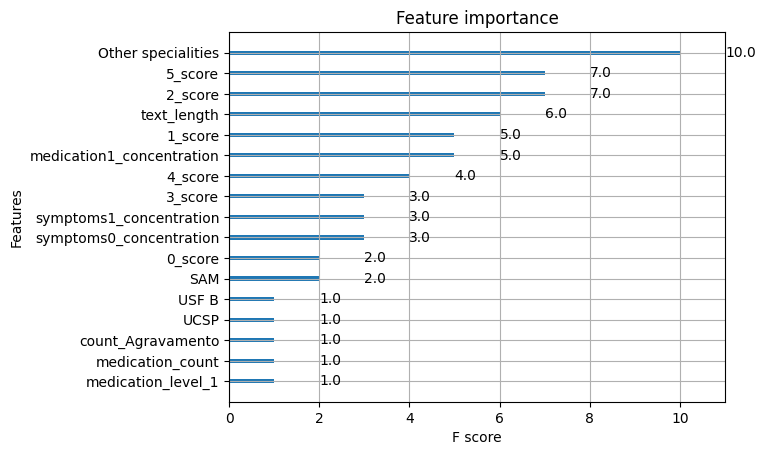

In [23]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [25]:
# columns_bert = ['accep_prot_0', 'accep_prot_1', 'accep_prot_2', 'accep_prot_3', 'accep_prot_4', 'accep_prot_5', 'rej_prot_0', 'rej_prot_1', 'rej_prot_2', 'rej_prot_3', 'rej_prot_4', 'rej_prot_5', 'rej_prot_6', 'rej_prot_7']
# columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5','rej_prot_0','rej_prot_1','rej_prot_2','rej_prot_3','rej_prot_4','rej_prot_5','rej_prot_6','rej_prot_7']



data[desirable].describe()

,0_score,1_score,2_score,3_score,4_score,5_score
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,0.293335,0.366071,0.362067,0.268869,0.325324,0.382068
std,0.112788,0.102611,0.082276,0.069603,0.102831,0.095582
min,-0.037176,0.086008,0.098522,-0.024949,0.000980,0.112181
25%,0.237465,0.290825,0.303780,0.230177,0.253060,0.329731
50%,0.279113,0.391306,0.361239,0.279000,0.319434,0.380027
75%,0.337517,0.406086,0.404751,0.306888,0.383931,0.417537
max,1.000000,1.000000,1.000000,0.572718,0.717770,1.000000


In [26]:
data2 = data.copy()


# Calculate quartiles for each score column
score_cols = desirable  # replace with your actual column names
quartile_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile', '90_quantile']
for col in score_cols:
    quartile_bins = [0, data2[col].quantile(0.25), data2[col].quantile(0.5), data2[col].quantile(0.75), data2[col].quantile(0.90), float('inf')]
    data2[col + '_quartile'] = pd.cut(data2[col], bins=quartile_bins, labels=quartile_labels)
    # data2[col + '_flag'] = (data2[col + '_quartile'] == quartile_labels[0]).astype(int)


In [27]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 80 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [28]:
results = pd.DataFrame({'quartile': quartile_labels})

columns_quartile = ['0_score_quartile','1_score_quartile','2_score_quartile','3_score_quartile','4_score_quartile','5_score_quartile']


for i , col in enumerate(columns_quartile):
    teste = data2.groupby(col)['result'].sum().reset_index()
    teste.rename(columns={'result': 'sum_'+str(i)}, inplace=True)
    teste2 = data2.groupby(col)['result'].count().reset_index()
    teste2.rename(columns={'result': 'count_'+str(i)}, inplace=True)
    results = results.merge(teste, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results = results.merge(teste2, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results[desirable[i]] = results['sum_'+str(i)]/results['count_'+str(i)]
    results = results.drop(['sum_'+str(i),'count_'+str(i)],axis=1)
  


results

,quartile,0_score,1_score,2_score,3_score,4_score,5_score
0,1st Quartile,0.673367,0.456576,0.436725,0.716418,0.485437,0.699752
1,2nd Quartile,0.538627,0.743781,0.713930,0.721393,0.720102,0.726368
2,3rd Quartile,0.813609,0.739872,0.783582,0.500000,0.721393,0.517413
3,4th Quartile,0.784232,0.798851,0.767635,0.796680,0.792531,0.771784
4,90_quantile,0.689441,0.807453,0.844720,0.788820,0.838509,0.813665


## Model with  A1 and A4 only

In [29]:
desirable = ['1_score','4_score']

undesirable = ['0_score','2_score','3_score','5_score']

In [30]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text'] + undesirable
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [31]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.82,0.96,0.81,0.88
1,Precision-Recall trade-off,0.50,0.82,0.97,0.81,0.87
2,Balanced Accuracy,0.68,0.77,0.75,0.89,0.93
3,Cohen's Kappa,0.59,0.81,0.90,0.84,0.90
4,Limit to K,0.64,0.79,0.82,0.87,0.90


In [32]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.71,0.97,0.70,0.70
1,Precision-Recall trade-off,0.50,0.70,0.97,0.70,0.70
2,Balanced Accuracy,0.68,0.73,0.75,0.82,0.78
3,Cohen's Kappa,0.59,0.70,0.86,0.73,0.73
4,Limit to K,0.64,0.72,0.79,0.78,0.79


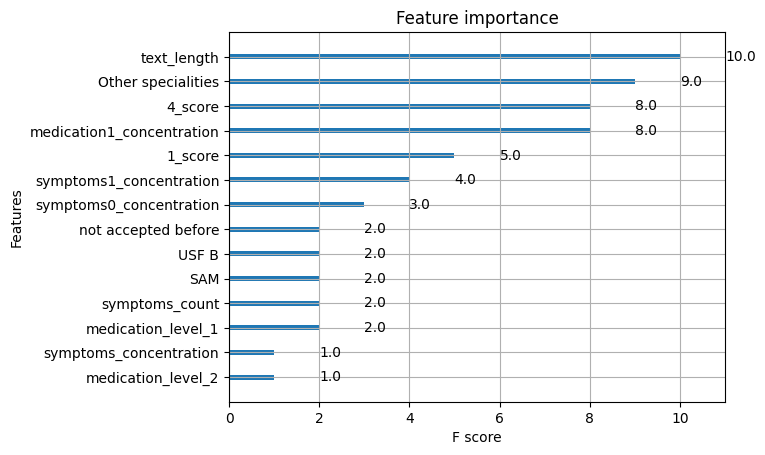

In [33]:
# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [52]:
one_score = data.nsmallest(10, '1_score')[['COD_REFERENCIA','Texto','result']]
four_score = data.nsmallest(10, '4_score')[['COD_REFERENCIA','Texto','result']]


In [53]:
one_score

,COD_REFERENCIA,Texto,result
1323,LSHLOTOV,"11 anos Sindroam de Charcot - marie Tooth, co...",0
1095,LRHQSVHS,Doente JP,1
414,LPHPVOPO,amnésia,1
1239,LRHTTLLP,AIT sensitivo,0
1329,LSHLPROO,"Puérpera de 5 dias, com hemicefaleia e tontura...",0
676,LQHPPRQT,Status pos stent carotideo com oclusao carotid...,1
894,LRHHRQOQ,alt cog,1
269,LPHHRUQH,crises parciais,1
1036,LRHPPROH,doente chegou atrasada na ultima consulta e nã...,1
1424,LSHPVLTR,"avc alt cog doent dr of, jp",1


In [54]:
four_score

,COD_REFERENCIA,Texto,result
57,LOHLLRQP,Tremor,1
398,LPHPSPUR,Tremor,1
619,LQHLVVSL,tremor,0
505,LPHRSSQT,Tremor acentuado,0
1095,LRHQSVHS,Doente JP,1
1419,LSHPTVHT,avc estenose carotidea,1
637,LQHOPSQL,miastenia,1
633,LQHOPSPV,miastenia,1
783,LQHRPSHL,miastenia,1
20,LOHHPVPS,ELA,0
